In [1]:
import sys
import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import griddata
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.colors as colors

#!apt-get update
#!apt --fix-broken install
#plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams["text.usetex"] = True
#rcParams.update({'figure.autolayout': True})
# !dpkg --configure -a
#!apt-get install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
# !apt-get install cm-super dvipng

In [2]:
# Original Paths
# path       = '/content/drive/My Drive/Pandurata_ULX/'
# fileIn     = path+'data_ULXa9r50/'
# fileOut    = path+'figures_ULXa9r50/'

path       = '../data/'
fileIn     = path
fileOut    = '../figures_ULX/'

styleString   = ['o-', 's-.', '^--', '+-', 'x-.', 'd:']
color         = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
labelString   = ['Disk', 'Disk Scatter', 'Corona Scatter', 'Disk \& Corona', 'Corona++', 'Corona++ Disk']
labelObs      = ['$18^\circ$', '$45^\circ$', '$72^\circ$']
observerIndex = [40, 38, 36]   # 40 39 37

save_eps = False
save_pdf = True
save_png = True
cgs  = False
lbs  = 14   # Label font size

fileIndex = '0624'
Nth_obs = 41
Nph_obs = 39
emin = 0.001
emax = 10000.
Ne = 101
Ne_obs = 10
Ni = 81

nStart = 624
nEnd   = 625
nStep  = 1

sort_cut = 4

In [3]:
#@title General Functions
def readgrid():
  f1 = open(fileIn+'gr_'+fileIndex+'_new.dat','r')
  line = f1.readline()
  p1 = line.split()
  global Nr, Nt, Np
  Nr = int(p1[0])
  Nt = int(p1[1])
  Np = int(p1[2])
  line = f1.readline()
  p1 = line.split()
  for i in range(Nr):
    r.append(float(p1[i]))
  line = f1.readline()
  p1 = line.split()
  for j in range(Nt):
    th.append(float(p1[j]))
  line = f1.readline()
  p1 = line.split()
  for k in range(Np):
    ph.append(float(p1[k]))
  f1.close()
  return

def readvarindex(file, index, yUnit):
  f1 = open(file,'r')
  y = []
  count = 0
  for line in f1:
    if count == index:
      p1 = line.split()
      for i in range(len(p1)):
        y.append(float(p1[i])*yUnit)
    count += 1
  f1.close()
  return y

def readvarslice(file, index, zUnit):
  f1 = open(file,'r')
  z = []
  for line in f1:
    p1 = line.split()
    if zLog:
      z.append(np.log10(np.abs(float(p1[index]))*zUnit+1.))
    else:
      z.append(np.abs(float(p1[index]))*zUnit+1.)
  f1.close()
  return z

def readvarxyz(file, index, zUnit):
  f1 = open(file,'r')
  x = np.arange(Ni)
  y = np.arange(Ni)
  z = []
  # This reads what comes from Pandurata for the total intensity
  # count = 0
  # for line in f1:
  #   if (count >= Ni*index and count < Ni*(index+1)):
  #     #z.append([])
  #     p1 = line.split()
  #     for i in range(len(p1)):
  #       z.append(float(p1[i])*zUnit)
  #   count += 1
  # f1.close()
  count = 0
  for line in f1:
    if (count >= (Nth_obs*Ni+index*Ni*Ni) and count < (Nth_obs*Ni+(index+1)*Ni*Ni)):
      #z.append([])
      p1 = line.split()
      z.append(float(p1[0])*zUnit)
    count += 1
  f1.close()
  for isort in range(1,sort_cut):
    f1 = open(file,'r')
    count = 0
    count2 = 0
    for line in f1:
      if (count >= (Nth_obs*Ni+index*Ni*Ni) and count < (Nth_obs*Ni+(index+1)*Ni*Ni)):
        #z.append([])
        p1 = line.split()
        z[count2] += float(p1[isort])*zUnit
        count2 += 1
      count += 1
    f1.close()
  return x,y,z

def readvarz_s(file, index, zUnit, isort):
  f1 = open(file,'r')
  z = []
  count = 0
  for line in f1:
    if (count >= (Nth_obs*Ni+index*Ni*Ni) and count < (Nth_obs*Ni+(index+1)*Ni*Ni)):
      #z.append([])
      p1 = line.split()
      z.append(float(p1[isort])*zUnit)
    count += 1
  f1.close()
  return z

def readvector(file, index):
  f1 = open(file,'r')
  x = []
  y = []
  u = []
  v = []
  count = 0
  for line in f1:
    if (count >= Ni*index and count < Ni*(index+1)):
      p1 = line.split()
      for i in range(len(p1)):
        #x.append(i)
        x.append(Ni-i-1)  # Pandurata flips the image, so this flips it back
        #y.append(count-Ni*index)
        y.append(Ni*(index+1)-count-1)  # Pandurata flips the image, so this flips it back
    count += 1
  f1.close()
  # This reads what comes from Pandurata for the total i, q & u
  # count = 0
  # for line in f1:
  #   if (count >= Ni*index and count < Ni*(index+1)):
  #     p1 = line.split()
  #     for i in range(len(p1)):
  #       u.append(float(p1[i]))
  #   if (count >= (Nth_obs*Ni+Ni*index) and count < (Nth_obs*Ni+Ni*(index+1))):
  #     p1 = line.split()
  #     for i in range(len(p1)):
  #       v.append(float(p1[i]))
  #   count += 1
  # f1.close()
  f1 = open(file,'r')
  count = 0
  for line in f1:
    if (count >= (2*Nth_obs*Ni+index*Ni*Ni) and count < (2*Nth_obs*Ni+(index+1)*Ni*Ni)):
      p1 = line.split()
      u.append(float(p1[0]))
    if (count >= (2*Nth_obs*Ni+Nth_obs*Ni*Ni+index*Ni*Ni) and count < (2*Nth_obs*Ni+Nth_obs*Ni*Ni+(index+1)*Ni*Ni)):
      p1 = line.split()
      v.append(float(p1[0]))
    count += 1
  f1.close()
  for isort in range(1,sort_cut):
    f1 = open(file,'r')
    count = 0
    count2 = 0
    count3 = 0
    for line in f1:
      if (count >= (2*Nth_obs*Ni+index*Ni*Ni) and count < (2*Nth_obs*Ni+(index+1)*Ni*Ni)):
        p1 = line.split()
        u[count2] += float(p1[isort])
        count2 += 1
      if (count >= (2*Nth_obs*Ni+Nth_obs*Ni*Ni+index*Ni*Ni) and count < (2*Nth_obs*Ni+Nth_obs*Ni*Ni+(index+1)*Ni*Ni)):
        p1 = line.split()
        v[count3] += float(p1[isort])
        count3 += 1
      count += 1
    f1.close()
  return x,y,u,v

def readvector_s(file, index, isort):
  f1 = open(file, 'r')
  u = []
  v = []
  count = 0
  for line in f1:
    if (count >= (2*Nth_obs*Ni+index*Ni*Ni) and count < (2*Nth_obs*Ni+(index+1)*Ni*Ni)):
      p1 = line.split()
      u.append(float(p1[isort]))
    if (count >= (2*Nth_obs*Ni+Nth_obs*Ni*Ni+index*Ni*Ni) and count < (2*Nth_obs*Ni+Nth_obs*Ni*Ni+(index+1)*Ni*Ni)):
      p1 = line.split()
      v.append(float(p1[isort]))
    count += 1
  f1.close()
  return u,v

def readvariqu(file, index):
  f1 = open(file,'r')
  i = []
  q = []
  u = []
  count = 0
  # This reads what comes from Pandurata for the total i, q & u
  # for line in f1:
  #   if (count == index):
  #     p1 = line.split()
  #     for j in range(len(p1)):
  #       i.append(float(p1[j]))
  #   if (count == Nth_obs+index):
  #     p1 = line.split()
  #     for j in range(len(p1)):
  #       q.append(float(p1[j]))
  #   if (count == 2*Nth_obs+index):
  #     p1 = line.split()
  #     for j in range(len(p1)):
  #       u.append(float(p1[j]))
  #   count += 1
  # This reconstructs i, q & u from the chosen components
  for line in f1:
    if (count == 3*Nth_obs+index):
      p1 = line.split()
      for j in range(len(p1)):
        i.append(float(p1[j]))
    if (count == 3*Nth_obs+6*Nth_obs+index):
      p1 = line.split()
      for j in range(len(p1)):
        q.append(float(p1[j]))
    if (count == 3*Nth_obs+12*Nth_obs+index):
      p1 = line.split()
      for j in range(len(p1)):
        u.append(float(p1[j]))
    count += 1
  f1.close()
  for isort in range(1,sort_cut):
    f1 = open(file,'r')
    count = 0
    for line in f1:
      if (count == 3*Nth_obs+isort*Nth_obs+index):
        p1 = line.split()
        for j in range(len(p1)):
          i[j] += float(p1[j])
      if (count == 3*Nth_obs+6*Nth_obs+isort*Nth_obs+index):
        p1 = line.split()
        for j in range(len(p1)):
          q[j] += float(p1[j])
      if (count == 3*Nth_obs+12*Nth_obs+isort*Nth_obs+index):
        p1 = line.split()
        for j in range(len(p1)):
          u[j] += float(p1[j])
      count += 1
    f1.close()
  return i,q,u


def readvariqus(file, index, isort):
  f1 = open(file,'r')
  i = []
  q = []
  u = []
  count = 0
  for line in f1:
    if (count == 3*Nth_obs+isort*Nth_obs+index):
      p1 = line.split()
      for j in range(len(p1)):
        i.append(float(p1[j]))
    if (count == 3*Nth_obs+6*Nth_obs+isort*Nth_obs+index):
      p1 = line.split()
      for j in range(len(p1)):
        q.append(float(p1[j]))
    if (count == 3*Nth_obs+12*Nth_obs+isort*Nth_obs+index):
      p1 = line.split()
      for j in range(len(p1)):
        u.append(float(p1[j]))
    count += 1
  f1.close()
  return i,q,u

def photosphereRz(model_file,index):
  f1 = open(model_file,'r')

  x = []
  y = []
  count = 0
  for line in f1:
    # Top surface of photosphere
    if count == 3*Np+index:
      p1 = line.split()
      for i in range(Nr):
        theta = float(p1[i])
        x.append(r[i]*np.sin(theta))
        y.append(r[i]*np.cos(theta))
    # Bottom surface of photosphere
    if count == 4*Np+index:
      p1 = line.split()
      for i in range(Nr-1,-1,-1):
        theta = float(p1[i])
        x.append(r[i]*np.sin(theta))
        y.append(r[i]*np.cos(theta))
    count += 1

  f1.close()
  return x,y

def areaAverage(x,y,u,v):
  xAvg = []
  yAvg = []
  uAvg = []
  vAvg = []
  blockLen = 9
  numBlocks = len(u)//blockLen//blockLen
  numBlocksX = int(np.sqrt(numBlocks))
  for n in range(numBlocks):
    nAvg = 0.
    xAvg.append((n%numBlocksX)*blockLen+blockLen//2)
    yAvg.append((n//numBlocksX)*blockLen+blockLen//2)
    luAvg = 0.
    lvAvg = 0.
    for j in range(blockLen):
      for i in range(blockLen):
        # lu = u[(n//blockLen)*blockLen**3+(n%blockLen)*blockLen+j*blockLen*blockLen+i]
        # lv = v[(n//blockLen)*blockLen**3+(n%blockLen)*blockLen+j*blockLen*blockLen+i]
        lu = u[(n//numBlocksX)*numBlocksX*blockLen**2+j*numBlocksX*blockLen+(n%numBlocksX)*blockLen+i]
        lv = v[(n//numBlocksX)*numBlocksX*blockLen**2+j*numBlocksX*blockLen+(n%numBlocksX)*blockLen+i]
        if((lu*lu+lv*lv) > 0.):
          luAvg += lu
          lvAvg += lv
          nAvg += 1.
    if(nAvg > 0.):
      luAvg /= nAvg
      lvAvg /= nAvg
    uAvg.append(luAvg)
    vAvg.append(lvAvg)
  return xAvg,yAvg,uAvg,vAvg

def getvectors(ix,iy,z):
  #xv = []
  #yv = []
  u = []
  v = []
  maxdeg = 0.
  for i in range(len(ix)):
    u.append(0.)
    v.append(0.)
    if(z[i] > zmin):
      u[i] = ix[i]/z[i]*100.
      v[i] = iy[i]/z[i]*100.
      deg = np.sqrt(u[i]*u[i]+v[i]*v[i])
      maxdeg = max(deg,maxdeg)
      if zLog:
        z[i] = np.log10(z[i])
    #xv.append(xx[i])
    #yv.append(yy[i])
  return u,v,z,maxdeg


In [4]:
#@title Plotting Functions

def makeIronLinePlot():
  fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
  for i in range(len(observerIndex)):
    y = readvarindex(fileName,observerIndex[i],yUnit)
    plt.plot(nu,y,styleString[0])

  plt.xlim([xmin,xmax])
  plt.ylim([ymin,ymax])
  plt.xscale("log")
  if yLog:
    plt.yscale("log")
  plt.xlabel('$E [\mathrm{keV}]$',fontsize=lbs)
  plt.ylabel(r'$\nu L_\nu [\mathrm{erg~s^{-1}}]$',fontsize=lbs)
  plt.tick_params(axis='both', which='both', direction='in', labelsize=lbs,top=True,right=True)
  plt.legend(loc=2,ncol=1,prop={'size':(lbs-2)},frameon=False)
  if(save_eps):
    plt.savefig(fileOut+fileBase+".eps", format='eps',transparent='True')
  if(save_pdf):
    plt.savefig(fileOut+fileBase+".pdf", format='pdf',transparent='True')
  if(save_png):
    plt.savefig(fileOut+fileBase+".png", format='png',transparent='True')


def makeRadialSpectrumPlot():
  fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
  y = readvarindex(fileName,radialIndex,yUnit)
  plt.plot(nu,y,styleString[0])

  plt.xlim([xmin,xmax])
  plt.ylim([ymin,ymax])
  plt.xscale("log")
  if yLog:
    plt.yscale("log")
  plt.xlabel('$E [\mathrm{keV}]$',fontsize=lbs)
  plt.ylabel(r'$\nu L_\nu [\mathrm{erg~s^{-1}}]$',fontsize=lbs)
  plt.tick_params(axis='both', which='both', direction='in', labelsize=lbs,top=True,right=True)
  plt.legend(loc=2,ncol=1,prop={'size':(lbs-2)},frameon=False)
  if(save_eps):
    plt.savefig(fileOut+fileBase+".eps", format='eps',transparent='True')
  if(save_pdf):
    plt.savefig(fileOut+fileBase+".pdf", format='pdf',transparent='True')
  if(save_png):
    plt.savefig(fileOut+fileBase+".png", format='png',transparent='True')


def makeSpectrumPlot():
  fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
  for n in range(len(observerIndex)):
    ispec,qspec,uspec = readvariqu(fileName,observerIndex[n])
    for i in range(len(nu)):
      ispec[i] *= nu[i]*yUnit
    plt.plot(nu,ispec, styleString[n], label=labelObs[n])

  plt.xlim([xmin,xmax])
  plt.ylim([ymin,ymax])
  plt.xscale("log")
  if yLog:
    plt.yscale("log")
  plt.xlabel('$E [\mathrm{keV}]$',fontsize=lbs)
  plt.ylabel(r'$\nu L_\nu [\mathrm{erg~s^{-1}}]$',fontsize=lbs)
  plt.tick_params(axis='both', which='both', direction='in', labelsize=lbs,top=True,right=True)
  plt.legend(loc=2,ncol=1,prop={'size':(lbs-2)},frameon=False)
  if(save_eps):
    plt.savefig(fileOut+"spectrum.eps", format='eps',transparent='True')
  if(save_pdf):
    plt.savefig(fileOut+"spectrum.pdf", format='pdf',transparent='True')
  if(save_png):
    plt.savefig(fileOut+"spectrum.png", format='png',transparent='True')


def makeSpectralComponentPlot():
  fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
  for n in range(len(observerIndex)):
    plt.figure(n)
    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],0)
    for i in range(len(nu)):
      ispecs[i] *= nu[i]*yUnit
    plt.plot(nu,ispecs,styleString[0],label=labelString[0])

    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],1)
    for i in range(len(nu)):
      ispecs[i] *= nu[i]*yUnit
    plt.plot(nu,ispecs,styleString[1],label=labelString[1])

    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],2)
    for i in range(len(nu)):
      ispecs[i] *= nu[i]*yUnit
    plt.plot(nu,ispecs,styleString[2], label=labelString[2])

    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],3)
    for i in range(len(nu)):
      ispecs[i] *= nu[i]*yUnit
    plt.plot(nu,ispecs,styleString[3],label=labelString[3])

    # ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],4)
    # for i in range(len(nu)):
    #   ispecs[i] *= nu[i]*yUnit
    # plt.plot(nu,ispecs,styleString[4], label=labelString[4])

    # ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],5)
    # for i in range(len(nu)):
    #   ispecs[i] *= nu[i]*yUnit
    # plt.plot(nu,ispecs,styleString[5], label=labelString[5])

    ispec,qspec,uspec = readvariqu(fileName,observerIndex[n])
    for i in range(len(nu)):
      ispec[i] *= nu[i]*yUnit
    plt.plot(nu,ispec,color='black')

    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xscale("log")
    if yLog:
      plt.yscale("log")
    plt.xlabel('$E [\mathrm{keV}]$',fontsize=lbs)
    plt.ylabel(r'$\nu L_\nu [\mathrm{erg~s^{-1}}]$',fontsize=lbs)
    plt.tick_params(axis='both', which='both', direction='in', labelsize=lbs,top=True,right=True)
    plt.legend(loc=2,ncol=2,prop={'size':(lbs-2)},frameon=False)
    if(save_eps):
      plt.savefig(fileOut+"spectral_components_"+str(n)+".eps", format='eps',transparent='True')
    if(save_pdf):
      plt.savefig(fileOut+"spectral_components_"+str(n)+".pdf", format='pdf',transparent='True')
    if(save_png):
      plt.savefig(fileOut+"spectral_components_"+str(n)+".png", format='png',transparent='True')


def makePolarizationSpectrumPlot():
  fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
  plt.figure(1)
  for n in range(len(observerIndex)):
    ispec,qspec,uspec = readvariqu(fileName,observerIndex[n])
    deg = []
    for i in range(len(nu)):
      deg.append(np.sqrt(uspec[i]*uspec[i]+qspec[i]*qspec[i])/ispec[i]*100.)
    plt.plot(nu,deg,styleString[n],label=labelObs[n])

  plt.xlim([xmin,xmax])
  plt.ylim([ymin,ymax])
  plt.xscale("log")
  if yLog:
    plt.yscale("log")
  plt.xlabel('$E [\mathrm{keV}]$',fontsize=lbs)
  plt.ylabel('Polarization degree [\%]',fontsize=lbs)
  plt.tick_params(axis='both', which='both', direction='in', labelsize=lbs,top=True,right=True)
  plt.legend(loc=1,ncol=1,prop={'size':(lbs-2)},frameon=False)
  if(save_eps):
    plt.savefig(fileOut+"Pol_deg_spec.eps", format='eps',transparent='True')
  if(save_pdf):
    plt.savefig(fileOut+"Pol_deg_spec.pdf", format='pdf',transparent='True')
  if(save_png):
    plt.savefig(fileOut+"Pol_deg_spec.png", format='png',transparent='True')

  plt.figure(2)
  for n in range(len(observerIndex)):
    ispec,qspec,uspec = readvariqu(fileName,observerIndex[n])
    ang = []
    for i in range(len(nu)):
      ang.append(np.arctan2(uspec[i]/(ispec[i]+1.e30),qspec[i]/(ispec[i]+1.e30))/2.*180./np.pi)
    plt.plot(nu,ang,styleString[n],label=labelObs[n])

  plt.xlim([xmin,xmax])
  plt.ylim([-90.,90.])
  plt.xscale("log")
  if yLog:
    plt.yscale("log")
  plt.xlabel('$E [\mathrm{keV}]$',fontsize=lbs)
  plt.ylabel('Polarization angle [deg]',fontsize=lbs)
  plt.tick_params(axis='both', which='both', direction='in', labelsize=lbs,top=True,right=True)
  plt.legend(loc=1,ncol=1,prop={'size':(lbs-2)},frameon=False)
  if(save_eps):
    plt.savefig(fileOut+"Pol_ang_spec.eps", format='eps',transparent='True')
  if(save_pdf):
    plt.savefig(fileOut+"Pol_ang_spec.pdf", format='pdf',transparent='True')
  if(save_png):
    plt.savefig(fileOut+"Pol_ang_spec.png", format='png',transparent='True')


def makePolarizationSpectralComponentsPlot():
  fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
  for n in range(len(observerIndex)):
    plt.figure(2*n)
    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],0)
    deg = []
    for i in range(len(nu)):
      deg.append(np.sqrt(uspecs[i]*uspecs[i]+qspecs[i]*qspecs[i])/ispecs[i]*100.)
    plt.plot(nu,deg,styleString[0],label=labelString[0])

    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],1)
    deg = []
    for i in range(len(nu)):
      deg.append(np.sqrt(uspecs[i]*uspecs[i]+qspecs[i]*qspecs[i])/ispecs[i]*100.)
    plt.plot(nu,deg,styleString[1],label=labelString[1])

    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],2)
    deg = []
    for i in range(len(nu)):
      deg.append(np.sqrt(uspecs[i]*uspecs[i]+qspecs[i]*qspecs[i])/ispecs[i]*100.)
    plt.plot(nu,deg,styleString[2],label=labelString[2])

    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],3)
    deg = []
    for i in range(len(nu)):
      deg.append(np.sqrt(uspecs[i]*uspecs[i]+qspecs[i]*qspecs[i])/ispecs[i]*100.)
    plt.plot(nu,deg,styleString[3],label=labelString[3])

    # ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],4)
    # deg = []
    # for i in range(len(nu)):
    #   deg.append(np.sqrt(uspecs[i]*uspecs[i]+qspecs[i]*qspecs[i])/ispecs[i]*100.)
    # plt.plot(nu,deg,styleString[4],label=labelString[4])

    # ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],5)
    # deg = []
    # for i in range(len(nu)):
    #   deg.append(np.sqrt(uspecs[i]*uspecs[i]+qspecs[i]*qspecs[i])/ispecs[i]*100.)
    # plt.plot(nu,deg,styleString[5],label=labelString[5])

    ispec,qspec,uspec = readvariqu(fileName,observerIndex[n])
    deg = []
    for i in range(len(nu)):
      deg.append(np.sqrt(uspec[i]*uspec[i]+qspec[i]*qspec[i])/ispec[i]*100.)
    plt.plot(nu,deg,color='black')

    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xscale("log")
    if yLog:
      plt.yscale("log")
    plt.xlabel('$E [\mathrm{keV}]$',fontsize=lbs)
    plt.ylabel('Polarization degree [\%]',fontsize=lbs)
    plt.tick_params(axis='both', which='both', direction='in', labelsize=lbs,top=True,right=True)
    plt.legend(loc=2,ncol=2,prop={'size':(lbs-2)},frameon=False)
    if(save_eps):
      plt.savefig(fileOut+"Pol_deg_spec_"+str(n)+".eps", format='eps',transparent='True')
    if(save_pdf):
      plt.savefig(fileOut+"Pol_deg_spec_"+str(n)+".pdf", format='pdf',transparent='True')
    if(save_png):
      plt.savefig(fileOut+"Pol_deg_spec_"+str(n)+".png", format='png',transparent='True')

    plt.figure(2*n+1)
    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],0)
    ang = []
    for i in range(len(nu)):
      ang.append(np.arctan2(uspecs[i]/(ispecs[i]+1.e30),qspecs[i]/(ispecs[i]+1.e30))/2.*180./np.pi)
    plt.plot(nu,ang,styleString[0],label=labelString[0])

    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],1)
    ang = []
    for i in range(len(nu)):
      ang.append(np.arctan2(uspecs[i]/(ispecs[i]+1.e30),qspecs[i]/(ispecs[i]+1.e30))/2.*180./np.pi)
    plt.plot(nu,ang,styleString[1],label=labelString[1])

    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],2)
    ang = []
    for i in range(len(nu)):
      ang.append(np.arctan2(uspecs[i]/(ispecs[i]+1.e30),qspecs[i]/(ispecs[i]+1.e30))/2.*180./np.pi)
    plt.plot(nu,ang,styleString[2],label=labelString[2])

    ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],3)
    ang = []
    for i in range(len(nu)):
      ang.append(np.arctan2(uspecs[i]/(ispecs[i]+1.e30),qspecs[i]/(ispecs[i]+1.e30))/2.*180./np.pi)
    plt.plot(nu,ang,styleString[3],label=labelString[3])

    # ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],4)
    # ang = []
    # for i in range(len(nu)):
    #   ang.append(np.arctan2(uspecs[i]/(ispecs[i]+1.e30),qspecs[i]/(ispecs[i]+1.e30))/2.*180./np.pi)
    # plt.plot(nu,ang,styleString[4],label=labelString[4])

    # ispecs,qspecs,uspecs = readvariqus(fileName,observerIndex[n],5)
    # ang = []
    # for i in range(len(nu)):
    #   ang.append(np.arctan2(uspecs[i]/(ispecs[i]+1.e30),qspecs[i]/(ispecs[i]+1.e30))/2.*180./np.pi)
    # plt.plot(nu,ang,styleString[5],label=labelString[5])

    ispec,qspec,uspec = readvariqu(fileName,observerIndex[n])
    ang = []
    for i in range(len(nu)):
      ang.append(np.arctan2(uspec[i]/(ispec[i]+1.e30),qspec[i]/(ispec[i]+1.e30))/2.*180./np.pi)
    plt.plot(nu,ang,color='black')

    plt.xlim([xmin,xmax])
    plt.ylim([-90.,90.])
    plt.xscale("log")
    if yLog:
      plt.yscale("log")
    plt.xlabel('$E [\mathrm{keV}]$',fontsize=lbs)
    plt.ylabel('Polarization angle [deg]',fontsize=lbs)
    plt.tick_params(axis='both', which='both', direction='in', labelsize=lbs,top=True,right=True)
    plt.legend(loc=2,ncol=2,prop={'size':(lbs-2)},frameon=False)
    if(save_eps):
      plt.savefig(fileOut+"Pol_ang_spec_"+str(n)+".eps", format='eps',transparent='True')
    if(save_pdf):
      plt.savefig(fileOut+"Pol_ang_spec_"+str(n)+".pdf", format='pdf',transparent='True')
    if(save_png):
      plt.savefig(fileOut+"Pol_ang_spec_"+str(n)+".png", format='png',transparent='True')


def makePolarizationTimePlots():
  fileName = fileIn+'dump_times.dat'
  f1 = open(fileName,'r')
  t = []
  for line in f1:
    p1 = line.split()
    t.append(float(p1[0])*tUnit)
  f1.close()
  plt.figure(1)
  for o in range(len(observerIndex)):
    deg = []
    for n in range(nStart,nEnd,nStep):
      fileIndex = "{:04d}".format(n)
      fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
      ispec,qspec,uspec = readvariqu(fileName,observerIndex[o])
      i = energyIndex
      deg.append(np.sqrt(uspec[i]*uspec[i]+qspec[i]*qspec[i])/ispec[i]*100.)
    plt.plot(t,deg,styleString[o],label=labelObs[o])

  plt.xlim([xmin,xmax])
  plt.ylim([ymin,ymax])
  if xLog:
    plt.xscale("log")
  if yLog:
    plt.yscale("log")
  plt.xlabel('$t [GM/c^3]$',fontsize=lbs)
  plt.ylabel('Polarization degree [\%]',fontsize=lbs)
  plt.tick_params(axis='both', which='both', direction='in', labelsize=lbs,top=True,right=True)
  plt.legend(loc=2,ncol=1,prop={'size':(lbs-2)},frameon=False)
  if(save_eps):
    plt.savefig(fileOut+"Pol_deg_time.eps", format='eps',transparent='True')
  if(save_pdf):
    plt.savefig(fileOut+"Pol_deg_time.pdf", format='pdf',transparent='True')
  if(save_png):
    plt.savefig(fileOut+"Pol_deg_time.png", format='png',transparent='True')

  plt.figure(2)
  for o in range(len(observerIndex)):
    ang = []
    for n in range(nStart,nEnd,nStep):
      fileIndex = "{:04d}".format(n)
      fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
      ispec,qspec,uspec = readvariqu(fileName,observerIndex[o])
      i = energyIndex
      ang.append(np.arctan2(uspec[i]/ispec[i],qspec[i]/ispec[i])/2.*180./np.pi)
    plt.plot(t,ang,styleString[o],label=labelObs[o])

  plt.xlim([xmin,xmax])
  plt.ylim([-90.,90.])
  if xLog:
    plt.xscale("log")
  if yLog:
    plt.yscale("log")
  plt.xlabel('$t [GM/c^3]$',fontsize=lbs)
  plt.ylabel('Polarization angle [deg]',fontsize=lbs)
  plt.tick_params(axis='both', which='both', direction='in', labelsize=lbs,top=True,right=True)
  plt.legend(loc=2,ncol=1,prop={'size':(lbs-2)},frameon=False)
  if(save_eps):
    plt.savefig(fileOut+"Pol_ang_time.eps", format='eps',transparent='True')
  if(save_pdf):
    plt.savefig(fileOut+"Pol_ang_time.pdf", format='pdf',transparent='True')
  if(save_png):
    plt.savefig(fileOut+"Pol_ang_time.png", format='png',transparent='True')


def makePolarPlot():
  fig = plt.figure(figsize=(6, 5))
  gs = mpl.gridspec.GridSpec(1, 1)
  fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
  x = []
  y = []
  for i in range(Nr):
    for j in range(Nt):
      x.append(r[i]*np.sin(th[j]))
      y.append(r[i]*np.cos(th[j]))
  z = readvarslice(fileName,phiIndex,1.)
  
  levels = MaxNLocator(nbins=150).tick_values(zmin,zmax)
  plt.figure(1)
  ax = fig.add_subplot(gs[0, 0])
  plt.tricontourf(x,y,z,levels=levels,extend="both",cmap=colorMap)
  ax.set(xlim=(xmin,xmax))
  ax.set(ylim=(ymin,ymax))
  if cgs:
    plt.xlabel('$R~[\mathrm{km}]$',fontsize=lbs)
    plt.ylabel('$z~[\mathrm{km}]$',fontsize=lbs)
  else:
    plt.xlabel('$R~[GM/c^2]$',fontsize=lbs)
    plt.ylabel('$z~[GM/c^2]$',fontsize=lbs)
  plt.tick_params(axis='both', which='both', direction='in', labelsize=lbs,top=True,right=True)
  if photoSphere:
    fileName = fileIn+'ph_'+fileIndex+'_new.dat'
    xp,yp = photosphereRz(fileName,phiIndex)
    plt.plot(xp,yp,'w',lw=2)

  # cbar_ax = fig.add_axes([0.9,0.1,0.1,0.8])
  # cbar = fig.colorbar(im[len(modelName)-1],cax=cbar_ax,format=digForm,pad=0.02)
  cbar = plt.colorbar(format=digForm,pad=0.02)
  #cbar.set_label(zName,fontsize=lbs)
  #cbar.set_ticks([-10,-5,0,5,10])
  cbar.ax.tick_params(labelsize=lbs-2)

  if(save_eps):
    plt.savefig(fileOut+"Corona_power.eps", format='eps',transparent='True', bbox_inches="tight")
  if(save_pdf):
    plt.savefig(fileOut+"Corona_power.pdf", format='pdf',transparent='True', bbox_inches="tight")
  if(save_png):
    plt.savefig(fileOut+"Corona_power.png", format='png',transparent='True', bbox_inches="tight")

  # plt.figure(1)
  # zr = 0.
  # for k in range(Np):
  #   z = readvarslice(fileName,k,1.)
  #   zrtp = np.reshape(z,Nr, Nt)
  #   zr += integrate.trapezoid(zrtp, axis=1)

  # plt.plot(r, zr)


In [5]:
#@title Initial calculations
Nr = 0
Nt = 0
Np = 0
r = []
th = []
ph = []
readgrid()
nu = [0]*Ne
nu = emin*10.**(np.arange(Ne)/(float(Ne)-1.)*np.log10(emax/emin))

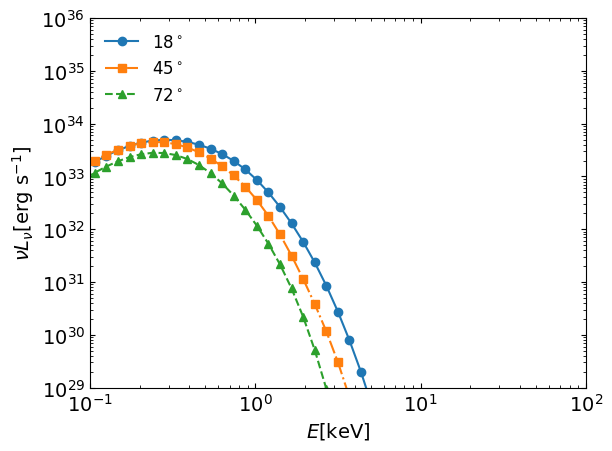

In [6]:
fileBase = 'scat_spec'
xmin = 0.1
xmax = 100.
ymin = 1.e29
ymax = 1.e36
yUnit = 2.41799e17*0.1  # 2.41799e17 Hz/keV to get units right and then factor of 0.1 to get the normalization better. Ultimately, the normalization is arbitrary.
yLog = True
makeSpectrumPlot()
# normalisation is much too low
# the peak of the spectra also slightly off
# perhaps these two things are linked and fixing the temperature may move the height of 

# in ph_ file the first 48 lines say whether there is a disc there or not
# the next 48 

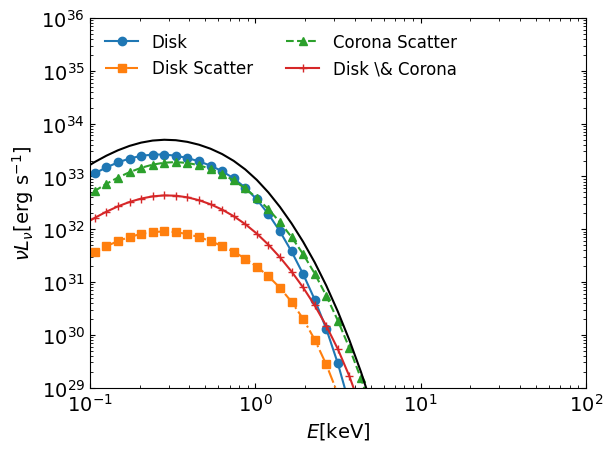

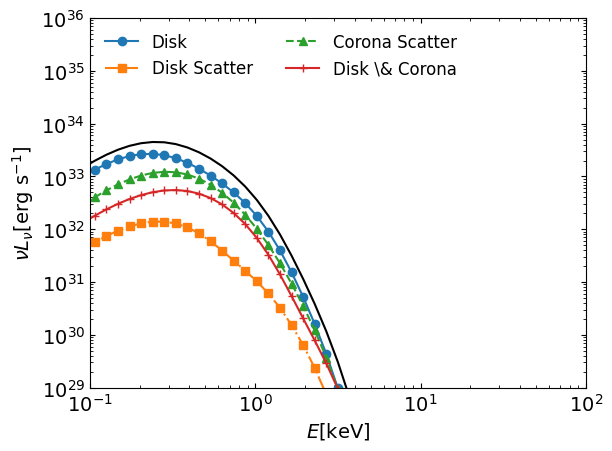

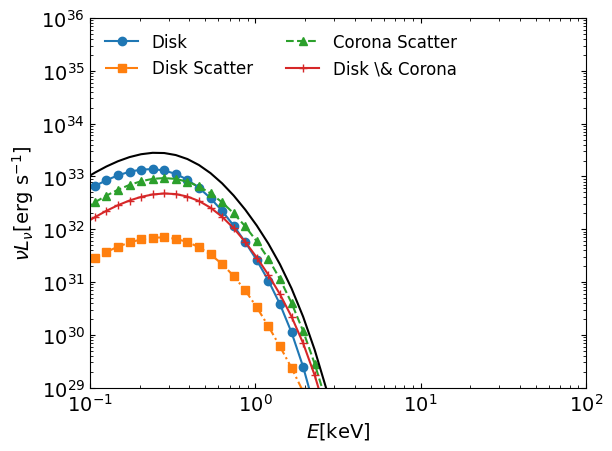

In [7]:
makeSpectralComponentPlot()

/tmp/ipykernel_11527/2862552047.py:136: RuntimeWarning: invalid value encountered in scalar divide
  deg.append(np.sqrt(uspec[i]*uspec[i]+qspec[i]*qspec[i])/ispec[i]*100.)


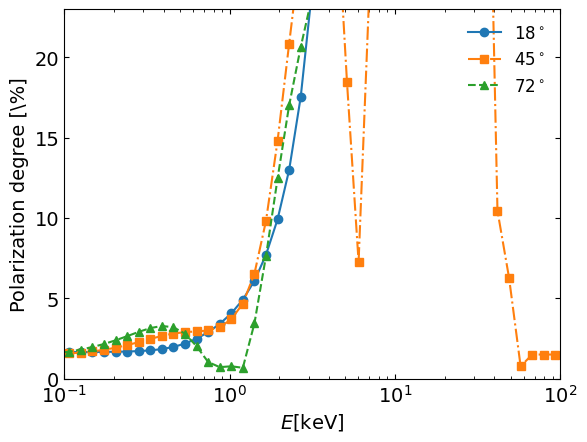

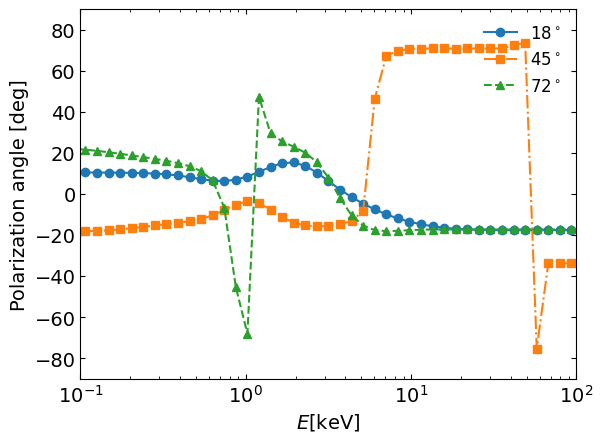

In [8]:
fileBase = 'scat_spec'
ymin = 0.
ymax = 23.
yLog = False
makePolarizationSpectrumPlot()

/tmp/ipykernel_11527/2862552047.py:187: RuntimeWarning: invalid value encountered in scalar divide
  deg.append(np.sqrt(uspecs[i]*uspecs[i]+qspecs[i]*qspecs[i])/ispecs[i]*100.)
/tmp/ipykernel_11527/2862552047.py:193: RuntimeWarning: invalid value encountered in scalar divide
  deg.append(np.sqrt(uspecs[i]*uspecs[i]+qspecs[i]*qspecs[i])/ispecs[i]*100.)
/tmp/ipykernel_11527/2862552047.py:199: RuntimeWarning: invalid value encountered in scalar divide
  deg.append(np.sqrt(uspecs[i]*uspecs[i]+qspecs[i]*qspecs[i])/ispecs[i]*100.)
/tmp/ipykernel_11527/2862552047.py:205: RuntimeWarning: invalid value encountered in scalar divide
  deg.append(np.sqrt(uspecs[i]*uspecs[i]+qspecs[i]*qspecs[i])/ispecs[i]*100.)
/tmp/ipykernel_11527/2862552047.py:223: RuntimeWarning: invalid value encountered in scalar divide
  deg.append(np.sqrt(uspec[i]*uspec[i]+qspec[i]*qspec[i])/ispec[i]*100.)
/tmp/ipykernel_11527/2862552047.py:187: RuntimeWarning: invalid value encountered in scalar divide
  deg.append(np.sqrt(

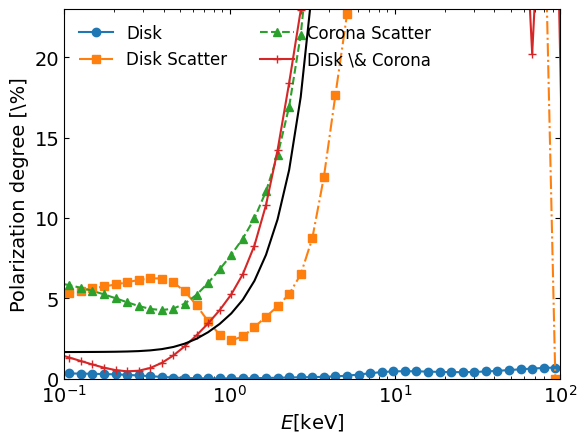

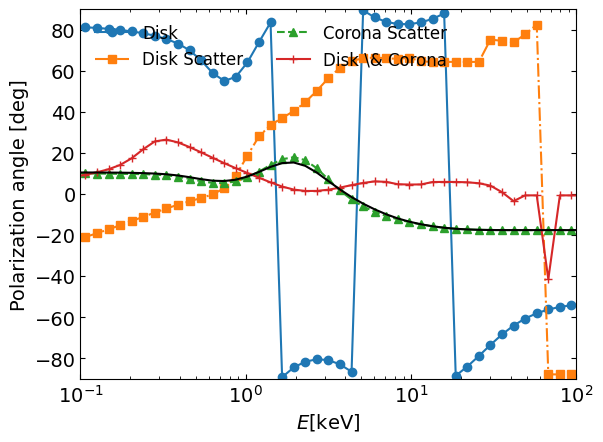

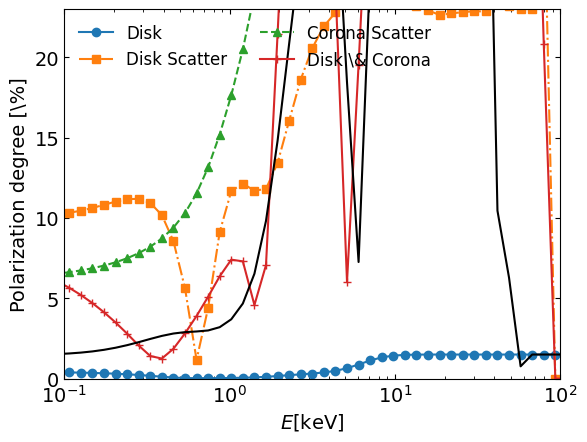

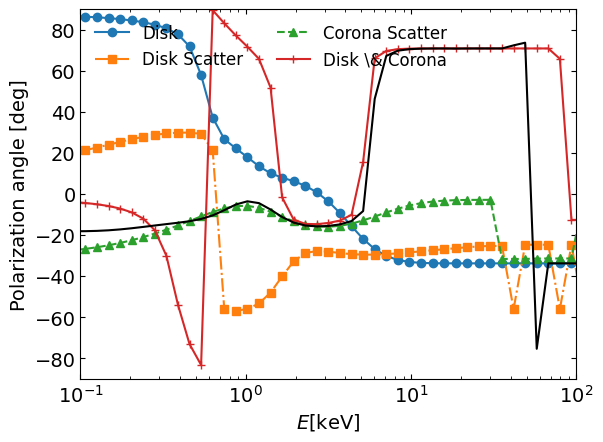

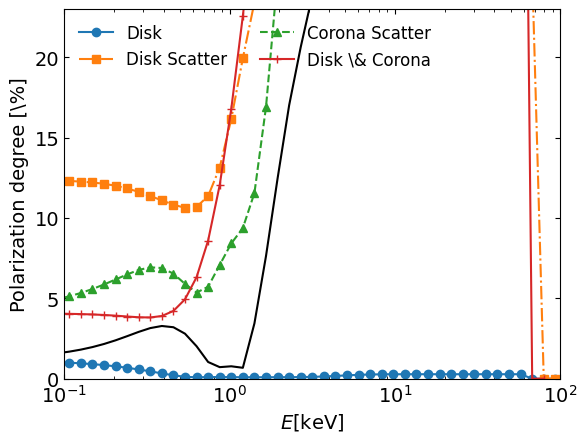

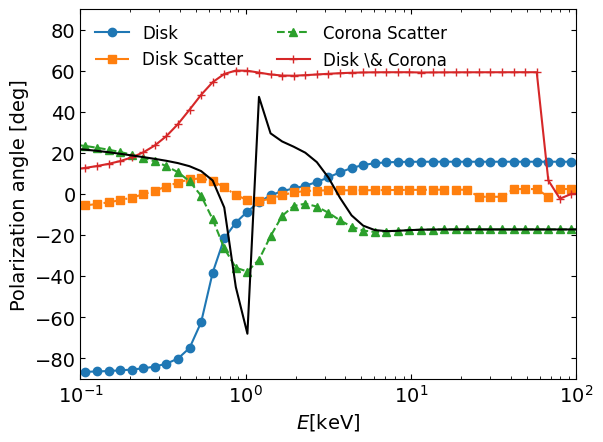

In [9]:
makePolarizationSpectralComponentsPlot()

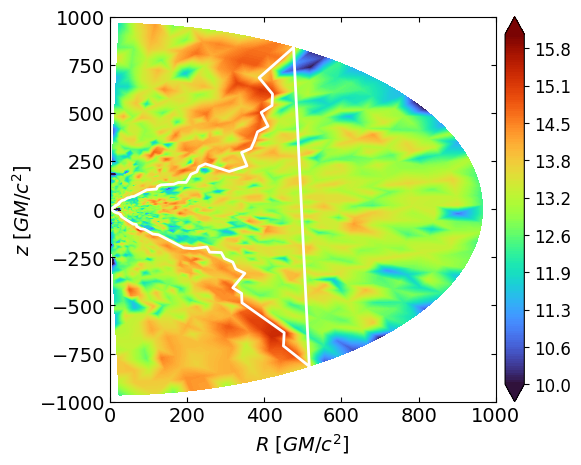

In [10]:
fileBase = 'scat_cpow'
xmin = 0.
xmax = 1000.
ymin = -1000.
ymax = 1000.
zmin = 10.
zmax = 16.
zLog = True
phiIndex = 0
colorMap = cm.turbo
digForm="%.1f"
photoSphere = True
makePolarPlot()

In [11]:
observerIndex

[40, 38, 36]

n=0
[179186000000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22152900000000.0, 0.0, 0.0, 0.0, 0.0, 14569900000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91110600000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7494130000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 261895000000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 133639000000000.0, 0.0, 0.0, 0.0, 0.0, 36928700000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26228900000000.0, 0.0, 2237600000000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5536420000000.0, 0.0, 0.0, 0.0, 0.0, 0.

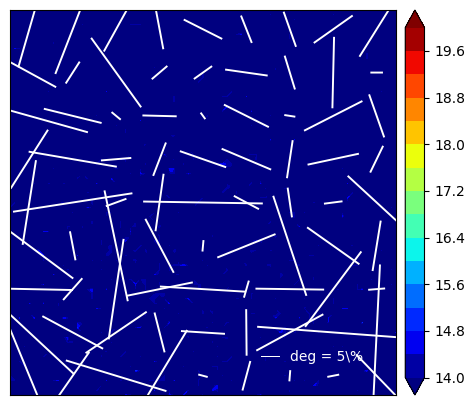

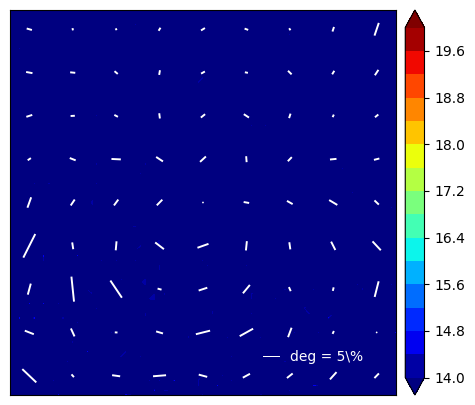

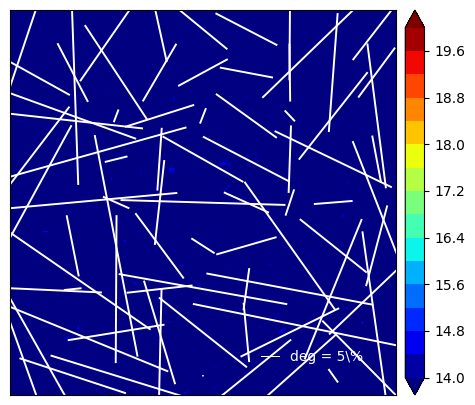

n=1
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

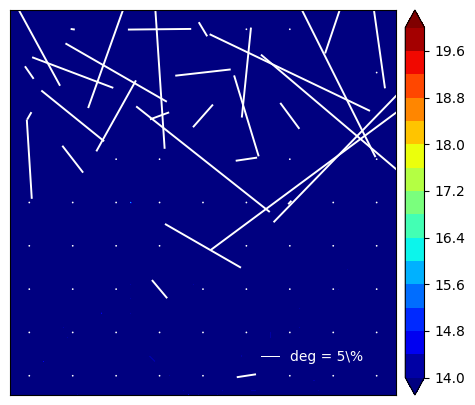

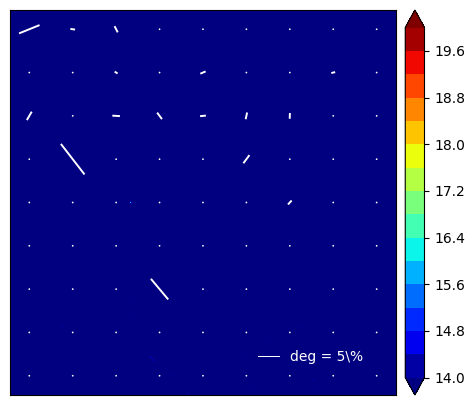

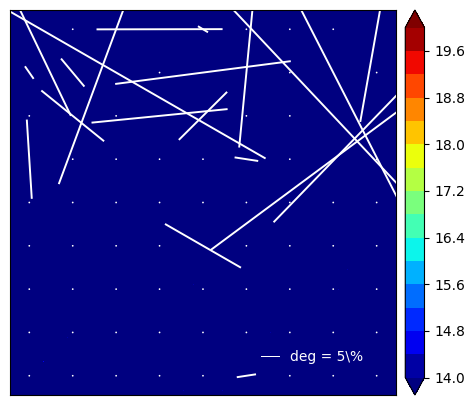

n=2
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

ZeroDivisionError: float division by zero

<Figure size 600x500 with 2 Axes>

ZeroDivisionError: float division by zero

<Figure size 600x500 with 2 Axes>

ZeroDivisionError: float division by zero

<Figure size 600x500 with 2 Axes>

In [12]:
zmin = 14.
zmax = 20.
zLog = True
zUnit = 1.
colorMap = cm.jet
digForm="%.1f"
#makePolarizationImages()


for n in range(len(observerIndex)):
    print(f'n={n}')

    fig = plt.figure(figsize=(6, 5))
    levels = MaxNLocator(nbins=15).tick_values(zmin, zmax)
    
    fileBase = 'scat_imag'
    fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
    x, y, z  = readvarxyz(fileName, observerIndex[n], zUnit)
    print(z)
    fileBase = 'scat_ipol'
    fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
    xx, yy, ix, iy     = readvector(fileName, observerIndex[n])
    u, v, z, maxdeg    = getvectors(ix, iy, z)
    xv, yv, uAvg, vAvg = areaAverage(xx, yy, u, v)

    ax = fig.add_subplot()
    #plt.contourf(x,y,z,levels=levels,extend="both",cmap=colorMap)
    m = ax.tricontourf(xx,yy,z,levels=levels,extend="both", cmap=colorMap)
    q = ax.quiver(xv,yv,uAvg,vAvg, color='white', width = 0.005, scale = maxdeg, headlength=0, headwidth = 1, pivot = 'middle')
    ax.quiverkey(q, X=0.7, Y=0.1, U=5, label='deg = 5\%', labelpos='E', labelcolor='white')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    cbar = plt.colorbar(m, format=digForm, pad=0.02)
    #cbar.set_label(zName,fontsize=lbs)
    #cbar.set_ticks([-10,-5,0,5,10])
    #cbar.ax.tick_params(labelsize=lbs-2)
    
    #if(save_eps):
    #  plt.savefig(fileOut+"image_full_"+str(n)+".eps", format='eps',transparent='True', bbox_inches="tight")
    #if(save_pdf):
    #  plt.savefig(fileOut+"image_full_"+str(n)+".pdf", format='pdf',transparent='True', bbox_inches="tight")
    #if(save_png):
    #  plt.savefig(fileOut+"image_full_"+str(n)+".png", format='png',transparent='True', bbox_inches="tight")


    fig = plt.figure(figsize=(6, 5))
    fileBase = 'scat_imag'
    fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
    zs = readvarz_s(fileName,observerIndex[n],zUnit,0)
    fileBase = 'scat_ipol'
    fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
    ixs,iys = readvector_s(fileName,observerIndex[n],0)
    us,vs,zs,maxdeg = getvectors(ixs,iys,zs)
    xvs,yvs,uAvg,vAvg = areaAverage(xx,yy,us,vs)
    
    ax = fig.add_subplot()
    #plt.contourf(x,y,z,levels=levels,extend="both",cmap=colorMap)
    m = ax.tricontourf(xx,yy,zs,levels=levels,extend="both",cmap=colorMap)
    q = ax.quiver(xvs,yvs,uAvg,vAvg, color='white', width = 0.005, scale = 10.*maxdeg, headlength=0, headwidth = 1, pivot = 'middle')
    ax.quiverkey(q, X=0.7, Y=0.1, U=5, label='deg = 5\%', labelpos='E', labelcolor='white')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    cbar = plt.colorbar(m, format=digForm,pad=0.02)
    #cbar.set_label(zName,fontsize=lbs)
    #cbar.set_ticks([-10,-5,0,5,10])
    #cbar.ax.tick_params(labelsize=lbs-2)
    
    #if(save_eps):
    #  plt.savefig(fileOut+"image_disk_"+str(n)+".eps", format='eps',transparent='True', bbox_inches="tight")
    #if(save_pdf):
    #  plt.savefig(fileOut+"image_disk_"+str(n)+".pdf", format='pdf',transparent='True', bbox_inches="tight")
    #if(save_png):
    #  plt.savefig(fileOut+"image_disk_"+str(n)+".png", format='png',transparent='True', bbox_inches="tight")
    
    fig = plt.figure(figsize=(6, 5))
    fileBase = 'scat_imag'
    fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
    zs = readvarz_s(fileName,observerIndex[n],zUnit,2)
    fileBase = 'scat_ipol'
    fileName = fileIn+fileBase+'.'+fileIndex+'.dat'
    ixs,iys = readvector_s(fileName, observerIndex[n], 2)
    us,vs,zs,maxdeg = getvectors(ixs,iys,zs)
    xvs,yvs,uAvg,vAvg = areaAverage(xx,yy,us,vs)
    
    ax = fig.add_subplot()
    #plt.contourf(x,y,z,levels=levels,extend="both",cmap=colorMap)
    m = ax.tricontourf(xx,yy,zs,levels=levels,extend="both",cmap=colorMap)
    q = ax.quiver(xvs,yvs,uAvg,vAvg, color='white', width = 0.005, scale = maxdeg, headlength=0, headwidth = 1, pivot = 'middle')
    ax.quiverkey(q, X=0.7, Y=0.1, U=5, label='deg = 5\%', labelpos='E', labelcolor='white')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    cbar = plt.colorbar(m, format=digForm,pad=0.02)
    #cbar.set_label(zName,fontsize=lbs)
    #cbar.set_ticks([-10,-5,0,5,10])
    #cbar.ax.tick_params(labelsize=lbs-2)
    
    #if(save_eps):
    #  plt.savefig(fileOut+"image_cor_"+str(n)+".eps", format='eps',transparent='True', bbox_inches="tight")
    #if(save_pdf):
    #  plt.savefig(fileOut+"image_cor_"+str(n)+".pdf", format='pdf',transparent='True', bbox_inches="tight")
    #if(save_png):
    #  plt.savefig(fileOut+"image_cor_"+str(n)+".png", format='png',transparent='True', bbox_inches="tight")
    plt.show()
    


In [13]:
pd.read_csv('../data/bb_0624_new.dat', sep='\t')

NameError: name 'pd' is not defined